# Exploration of NBA player data

## Name: Peisen Liu

# 1.Introduction
As a global sport, the evolution of basketball's competitive level and tactical strategies are closely related to the individual performance of players. We know that in sports events, it is very important to analyze and review the data of previous games. As the world's top basketball league, **NBA**'s player statistics are an excellent research object. By analyzing the key indicators of NBA players such as points, rebounds, assists, and shooting efficiency, we can not only understand the players' contributions in the game and their impact on the team's victory or defeat, but also provide guiding opinions on the **strategies** of each team and participating players.

# 2.Data Description
## 2.1.Module Import & Acquisition of Dataset
This project uses a comprehensive dataset covering NBA players' historical season performances, including basic information of players (such as name, position, age) and their game statistics (such as points, rebounds, assists, shooting percentage, etc.). The dataset contains multiple fields, including:

- Basic information: Year, player name (`Player`), position (`Pos`), age (`Age`), team (`Tm`).
- Game data: number of starts (`GS`), total playing time (`MP`), **field shooting percentage (`FG%`)**, **three-point shooting percentage (`3P%`)**, effective field goal percentage (`eFG%`), total rebounds (`TRB`), assists (`AST`)**, turnovers (`TOV`), **fouls (`PF`)**, total points (`PTS`)**, etc.

In [1]:
import requests
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

#from dash import Dash, dcc, html, Input, Output
import plotly.express as px
#import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

In [2]:
url = 'https://competition-oss.datafountain.cn/files-datafountain-cn/datasets/data/f526e27e-a65c-4510-80bc-58335e1680c6.zip'

current_directory = os.getcwd()

zip_filename = os.path.join(current_directory, 'NBA_Season_Stats.zip')


response = requests.get(url)


if response.status_code == 200:
    print("Download successful!")
    with open(zip_filename, 'wb') as file:
        file.write(response.content)
    print(f"The file is downloaded and saved as {zip_filename}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


if os.path.exists(zip_filename):
    print(f"File {zip_filename} exists.")
else:
    print(f"File {zip_filename} does not exist.")


with zipfile.ZipFile(zip_filename, "r") as zip_ref:
    extracted_files = zip_ref.namelist()
    
    
    zip_ref.extractall(current_directory)
    
    
    for file_name in extracted_files:
        extracted_file_path = os.path.join(current_directory, file_name)
        if os.path.exists(extracted_file_path):
            file_size_kb = os.path.getsize(extracted_file_path) / 1024  # 单位：KB
            print(f"{file_name} 100% [===================>] {file_size_kb:.2f} KB  --.-KB/s  in 0s")
        else:
            print(f"File {file_name} was not extracted properly.")


Download successful!
The file is downloaded and saved as d:\Desktop\INFO371-Final project-C1T2\NBA_Season_Stats.zip
File d:\Desktop\INFO371-Final project-C1T2\NBA_Season_Stats.zip exists.
NBA_Season_Stats.csv 100% [===================>] 4811.43 KB  --.-KB/s  in 0s
Team_stats.csv 100% [===================>] 48.84 KB  --.-KB/s  in 0s


## 2.2.Question1: Filling the Missing Values
We use the following strategy to process the dataset:
1. Convert Numeric Columns to Numeric Types
2. Replace Empty Strings with `NaN`
3. Fill Each Numeric Column with the **Average Value** for NaN Values
4. Remove Leading and Trailing Spaces.Use `df[column].str.strip()` on string columns to clean up spaces.
5.  Delete Data Before `1980`, because:
    1.  the **rule and statistical caliber of basketball game changed** a lot after 1980
    2.  there were too many missing values before 1980
6. Remove Corrupted Data Starting from Row 24624
7. Delete All Columns with "Unnamed"


In [3]:
csv_file = 'NBA_Season_Stats.csv'
filtered_csv_file = 'filtered_Player_data.csv'

# Read the CSV file using UTF-8 encoding
df = pd.read_csv(csv_file, encoding='utf-8')

# Keep only the first 24625 rows of data
df = df.iloc[:24624]

# Remove any columns whose names contain 'Unnamed'
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Remove rows with more than 2 missing values
df_filtered = df.dropna(thresh=len(df.columns) - 2)  # Keep rows with at least len(columns) - 2 non-null values

# Delete columns where all values are missing
df_filtered = df_filtered.dropna(axis=1, how='all')

# Process the Player column
# 1. Remove rows containing Chinese characters
df_filtered = df_filtered[~df_filtered['Player'].str.contains('[\u4e00-\u9fa5]', na=False)]

# 2. Remove any '*' characters from the Player column
df_filtered['Player'] = df_filtered['Player'].str.replace('*', '', regex=False)

# Save the processed data to a new CSV file, specifying UTF-8 encoding
df_filtered.to_csv(filtered_csv_file, index=False, encoding='utf-8')

print(f"Filtered data has been saved to {filtered_csv_file}")

Filtered data has been saved to filtered_Player_data.csv


In [4]:
csv_file = 'filtered_Player_data.csv'
filtered_csv_file = 'filtered_Player_data_with_avg.csv'

# Read the CSV file
df = pd.read_csv(csv_file, encoding='utf-8')

# Columns that need to be converted to integers
integer_columns = ['G', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

# Find columns with missing values
columns_with_na = df.columns[df.isna().any()].tolist()

# Calculate the average for each player in each data column
player_avg = df.groupby('Player')[columns_with_na].mean()

# Calculate the global average for each column (average across all players)
global_avg = df[columns_with_na].mean()

# Function to fill missing values
def fill_missing_values(row, column):
    if pd.isna(row[column]):
        # Get the player's average value, if the player doesn't have an average for this column, remove the player
        if row['Player'] in player_avg.index and not pd.isna(player_avg.loc[row['Player'], column]):
            player_value = player_avg.loc[row['Player'], column]
        else:
            # If the player doesn't have an average for this column, mark this row for removal
            return None  # Return None to indicate the row should be deleted
        
        # If the column is in the integer columns, round the value to an integer
        if column in integer_columns:
            return int(player_value)
        else:
            return player_value
    else:
        return row[column]

# Check if values in integer columns are integers
for column in integer_columns:
    df = df[pd.to_numeric(df[column], errors='coerce').apply(lambda x: x.is_integer() if pd.notna(x) else False)]

# Process each column with missing values
for column in columns_with_na:
    df[column] = df.apply(lambda row: fill_missing_values(row, column), axis=1)

# Save the processed data to a new CSV file
df.to_csv(filtered_csv_file, index=False, encoding='utf-8')

print(f"Processed data has been saved to {filtered_csv_file}")


Processed data has been saved to filtered_Player_data_with_avg.csv


To make subsequent operations more convenient, **separate the numeric column and the character column**

In [5]:
df = pd.read_csv("filtered_Player_data_with_avg.csv", encoding='utf-8')


str_columns = ['Player', 'Pos', 'Tm']
df[str_columns] = df[str_columns].apply(lambda x: x.str.strip())


num_columns = ['Year', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA',
               'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
               'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
               'BLK', 'TOV', 'PF', 'PTS']


for col in num_columns:
    
    df[col] = pd.to_numeric(df[col].replace('', np.nan), errors='coerce')


for col in num_columns:
    mean_value = df[col].mean()  
    df[col] = df[col].fillna(mean_value) 


print(df.head())


     Year          Player Pos   Age   Tm     G    GS      MP     FG     FGA  \
0  1980.0  Tiny Archibald  PG  31.0  BOS  80.0  80.0  2864.0  383.0   794.0   
1  1980.0      Larry Bird  PF  23.0  BOS  82.0  82.0  2955.0  693.0  1463.0   
2  1980.0       M.L. Carr  SF  29.0  BOS  82.0   7.0  1994.0  362.0   763.0   
3  1980.0      Don Chaney  SG  33.0  BOS  60.0   0.0   523.0   67.0   189.0   
4  1980.0     Dave Cowens   C  31.0  BOS  66.0  55.0  2159.0  422.0   932.0   

   ...    FT%    ORB    DRB    TRB    AST    STL   BLK    TOV     PF     PTS  
0  ...  0.830   59.0  138.0  197.0  671.0  106.0  10.0  242.0  218.0  1131.0  
1  ...  0.836  216.0  636.0  852.0  370.0  143.0  53.0  263.0  279.0  1745.0  
2  ...  0.739  106.0  224.0  330.0  156.0  120.0  36.0  143.0  214.0   914.0  
3  ...  0.762   31.0   42.0   73.0   38.0   31.0  11.0   33.0   80.0   167.0  
4  ...  0.779  126.0  408.0  534.0  206.0   69.0  61.0  108.0  216.0   940.0  

[5 rows x 30 columns]


Load the data from the `filtered_Player_data_with_avg.csv` file into a `DataFrame`. Remove leading and trailing spaces from the string columns `'Player'`, `'Pos'`, and `'Tm'`. Convert all numeric columns to numeric types and replace empty strings with `NaN`. For the `NaN` values in the numeric columns, fill them with the mean of the respective column.

In [6]:
df.describe()

,Year,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,18146.000000,18146.000000,18146.000000,18146.000000,18146.000000,18146.00000,18146.000000,18146.000000,18146.000000,18146.000000,...,18146.000000,18146.000000,18146.000000,18146.000000,18146.000000,18146.000000,18146.000000,18146.000000,18146.000000,18146.000000
mean,2001.016973,26.872809,49.662901,23.706492,1160.847625,183.97487,399.497079,0.437654,23.041607,65.846633,...,0.720107,59.602612,143.787281,203.389893,109.928249,38.500165,24.110878,71.763254,107.681087,484.096109
std,10.164833,4.024234,26.507661,28.654190,921.730660,179.84241,376.620217,0.097270,39.113967,103.903830,...,0.147852,65.364681,141.566518,201.291834,137.449467,37.509293,36.347169,65.844853,80.082337,477.242329
min,1980.000000,18.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1993.000000,24.000000,26.000000,0.000000,315.000000,36.00000,87.000000,0.400000,0.000000,1.000000,...,0.657000,12.000000,33.000000,47.000000,17.000000,9.000000,3.000000,17.000000,35.000000,95.000000
50%,2002.000000,26.000000,55.000000,8.000000,981.500000,129.00000,290.000000,0.444000,3.000000,13.000000,...,0.746000,36.000000,104.000000,145.000000,61.000000,28.000000,11.000000,54.000000,98.000000,336.000000
75%,2010.000000,30.000000,75.000000,45.000000,1888.000000,284.00000,616.000000,0.486000,30.000000,89.000000,...,0.812000,86.000000,209.000000,294.000000,150.000000,58.000000,29.000000,108.000000,168.000000,746.000000
max,2017.000000,44.000000,85.000000,83.000000,3533.000000,1098.00000,2279.000000,1.000000,402.000000,886.000000,...,1.000000,558.000000,1007.000000,1530.000000,1164.000000,301.000000,456.000000,464.000000,386.000000,3041.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18146 entries, 0 to 18145
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    18146 non-null  float64
 1   Player  18146 non-null  object 
 2   Pos     18146 non-null  object 
 3   Age     18146 non-null  float64
 4   Tm      18146 non-null  object 
 5   G       18146 non-null  float64
 6   GS      18146 non-null  float64
 7   MP      18146 non-null  float64
 8   FG      18146 non-null  float64
 9   FGA     18146 non-null  float64
 10  FG%     18146 non-null  float64
 11  3P      18146 non-null  float64
 12  3PA     18146 non-null  float64
 13  3P%     18146 non-null  float64
 14  2P      18146 non-null  float64
 15  2PA     18146 non-null  float64
 16  2P%     18146 non-null  float64
 17  eFG%    18146 non-null  float64
 18  FT      18146 non-null  float64
 19  FTA     18146 non-null  float64
 20  FT%     18146 non-null  float64
 21  ORB     18146 non-null  float64
 22

In [8]:
df.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1980.0,Tiny Archibald,PG,31.0,BOS,80.0,80.0,2864.0,383.0,794.0,...,0.830,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0
1,1980.0,Larry Bird,PF,23.0,BOS,82.0,82.0,2955.0,693.0,1463.0,...,0.836,216.0,636.0,852.0,370.0,143.0,53.0,263.0,279.0,1745.0
2,1980.0,M.L. Carr,SF,29.0,BOS,82.0,7.0,1994.0,362.0,763.0,...,0.739,106.0,224.0,330.0,156.0,120.0,36.0,143.0,214.0,914.0
3,1980.0,Don Chaney,SG,33.0,BOS,60.0,0.0,523.0,67.0,189.0,...,0.762,31.0,42.0,73.0,38.0,31.0,11.0,33.0,80.0,167.0
4,1980.0,Dave Cowens,C,31.0,BOS,66.0,55.0,2159.0,422.0,932.0,...,0.779,126.0,408.0,534.0,206.0,69.0,61.0,108.0,216.0,940.0


# 3.Question2: "level" of these players
On the basketball court, the performance of the players is directly related to the victory or defeat of the game. Therefore, the analysis of the players' strength is very important. We often hear commentators talk about the **"quality of the stars"**, which reflects the influence of the stars on the game.

In this section, we will use some key indicators to **classify players into different types** ("star players"
, "average players" and "replacement players") based on their statistical performance.
## 3.1.Basic Statistics
In order to have an **overall understanding** of the data to be used next, we first calculate the **three most basic statistics**, namely mode, median and mean

In [9]:
num_cols = 3  # Display 3 plots per row
valid_columns = df_filtered.select_dtypes(include=['float64', 'int64']).columns  # Select only numeric columns
# Calculate mean, median, and mode for valid columns
mean_values = df_filtered[valid_columns].mean()
median_values = df_filtered[valid_columns].median()
mode_values = df_filtered[valid_columns].mode().iloc[0]  # mode() returns a DataFrame, so we take the first row

# Display the results
print("Mean values:\n", mean_values)
print("\nMedian values:\n", median_values)
print("\nMode values:\n", mode_values)

Mean values:
 Year    2000.278967
Age       26.841842
G         49.901238
GS        23.706492
MP      1168.372682
FG       186.142273
FGA      403.365032
FG%        0.438293
3P        22.337778
3PA       63.955905
3P%        0.248796
2P       163.804495
2PA      339.409127
2P%        0.457237
eFG%       0.464144
FT        94.092281
FTA      124.935823
FT%        0.721773
ORB       60.465016
DRB      144.587420
TRB      205.052436
AST      111.192902
STL       38.983903
BLK       24.303671
TOV       72.966849
PF       108.869999
PTS      488.714604
dtype: float64

Median values:
 Year    2001.000
Age       26.000
G         55.000
GS         8.000
MP       993.000
FG       131.000
FGA      294.000
FG%        0.444
3P         3.000
3PA       12.000
3P%        0.292
2P       109.000
2PA      235.000
2P%        0.467
eFG%       0.475
FT        56.000
FTA       78.000
FT%        0.750
ORB       36.000
DRB      105.000
TRB      146.000
AST       62.000
STL       29.000
BLK       11.000
TOV   

## 3.2.show the players' levels
In this section, we will start with three indicators to analyze the level of players：
1. Total Points
2. Total Assists
3. Scoring Efficiency
### 3.2.1 Total Points


Mean: 3245.07
Median: 1022.0


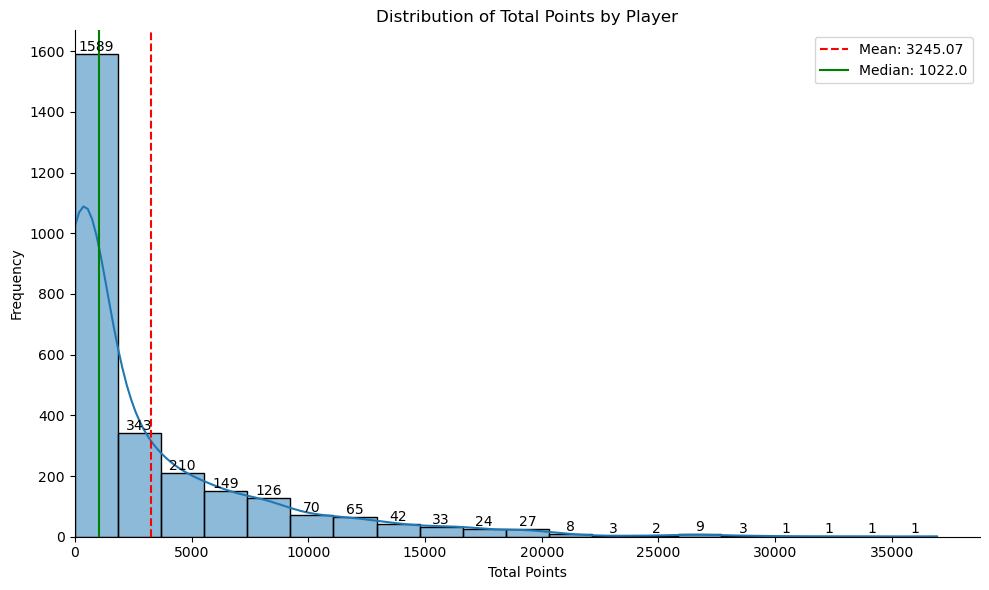

In [10]:
player_scores = df.groupby('Player')['PTS'].sum()

# Calculate mean and median (mode removed)
mean_score = player_scores.mean()
median_score = player_scores.median()

# Print mean and median
print(f'Mean: {mean_score:.2f}')
print(f'Median: {median_score}')

# Plot the histogram of score distribution
plt.figure(figsize=(10, 6))
ax = sns.histplot(player_scores, kde=True, bins=20)

# Annotate frequency above each bar
for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.text(x, height, f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Mark the mean and median on the chart (mode removed)
ax.axvline(mean_score, color='r', linestyle='--', label=f'Mean: {mean_score:.2f}')
ax.axvline(median_score, color='g', linestyle='-', label=f'Median: {median_score}')

# Set the legend
plt.legend()

# Set title and labels
plt.title('Distribution of Total Points by Player')
plt.xlabel('Total Points')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.ylabel('Frequency')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(False)

# Display the figure
plt.tight_layout()
plt.show()

- Mean: 3245.07
- Median: 1022.0

The scores are generally clustered below 1022

Distribution shape
Right skewed distribution Characteristics: The right tail is relatively long, and the score tends to be low, but there are a few players who score particularly high (high scores are outliers)

If the histogram shows that most of the data is concentrated on the left, but there is a long tail on the right, it indicates that most players have low scores, but there are a few players with abnormally high scores (for example, star players or top players have very high scores). This distribution is usually seen in situations where scores are highly uneven.

Observe the distribution shape and concentration:
- Skewness: Scores are more concentrated in low values
- Kurtosis: The distribution has a distinct single peak (left peak)
- Outlier: There is an extreme scoring system, with only one player scoring over 30000 points and exceeding 35000 points.

### 3.2.2. Total Assists

Mean AST: 736.89
Median AST: 188.0


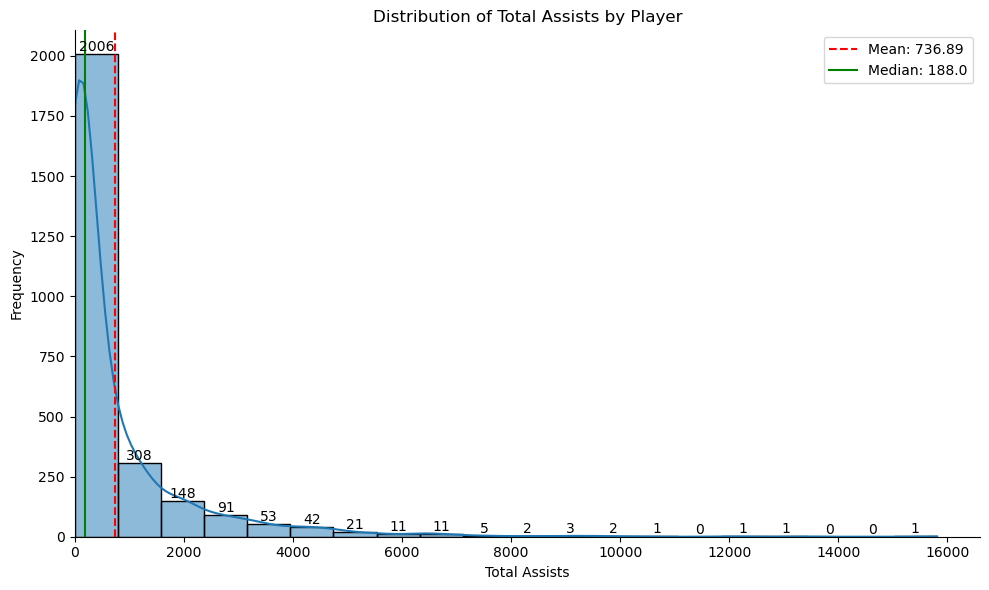

In [11]:
assist_scores = df.groupby('Player')['AST'].sum()

# Calculate mean and median (mode removed)
mean_ast = assist_scores.mean()
median_ast = assist_scores.median()

# Print mean and median
print(f'Mean AST: {mean_ast:.2f}')
print(f'Median AST: {median_ast}')

# Plot the histogram of assist distribution
plt.figure(figsize=(10, 6))
ax = sns.histplot(assist_scores, kde=True, bins=20)

# Annotate frequency above each bar
for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.text(x, height, f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Mark the mean and median on the chart
ax.axvline(mean_ast, color='r', linestyle='--', label=f'Mean: {mean_ast:.2f}')
ax.axvline(median_ast, color='g', linestyle='-', label=f'Median: {median_ast}')

# Set the legend and labels
plt.legend()
plt.title('Distribution of Total Assists by Player')
plt.xlabel('Total Assists')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.ylabel('Frequency')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(False)
plt.tight_layout()
plt.show()

- Mean: 736.89
- Median: 188.0

The assists are generally clustered below 188.0

Distribution shape
Right skewed distribution Characteristics: The right tail is relatively long, and the assists tends to be low, but there are a few players who assist particularly high (high assists are outliers)

If the histogram shows that most of the data is concentrated on the left, but there is a long tail on the right, it indicates that most players have low assists, but there are a few players with abnormally high assists (for example, star players or top players have very high assists,some players have IQ on basketball). This distribution is usually seen in situations where assists are highly uneven
Observe the distribution shape and concentration


- Skewness: Assists are more concentrated in low values
- Kurtosis: The distribution has a distinct single peak (left peak)
- Outlier: There is an extreme assisting system, with only one player assisting over 15000 points 

### 3.2.3Scoring Efficiency (PTS/FGA)

Mean Efficiency: 1.11
Median Efficiency: 1.13
Mode Efficiency: 1.00


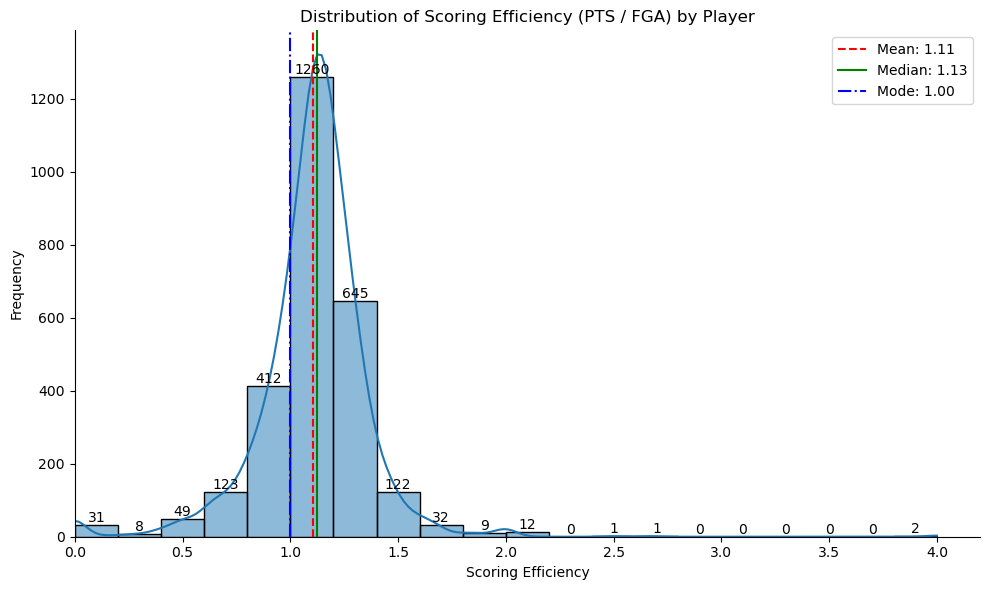

In [12]:
df['Efficiency'] = df['PTS'] / df['FGA']

efficiency_scores = df.groupby('Player')['Efficiency'].mean()


mean_eff = efficiency_scores.mean()
median_eff = efficiency_scores.median()
mode_eff = efficiency_scores.mode()[0]

print(f'Mean Efficiency: {mean_eff:.2f}')
print(f'Median Efficiency: {median_eff:.2f}')
print(f'Mode Efficiency: {mode_eff:.2f}')


plt.figure(figsize=(10, 6))
ax = sns.histplot(efficiency_scores, kde=True, bins=20)


for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.text(x, height, f'{int(height)}', ha='center', va='bottom', fontsize=10)

ax.axvline(mean_eff, color='r', linestyle='--', label=f'Mean: {mean_eff:.2f}')
ax.axvline(median_eff, color='g', linestyle='-', label=f'Median: {median_eff:.2f}')
ax.axvline(mode_eff, color='b', linestyle='-.', label=f'Mode: {mode_eff:.2f}')


plt.legend()
plt.title('Distribution of Scoring Efficiency (PTS / FGA) by Player')
plt.xlabel('Scoring Efficiency')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.ylabel('Frequency')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(False)
plt.tight_layout()
plt.show()


- Mean: 1.11
- Median: 1.13
The scoring efficiency is usually concentrated below 1.13.

**Right-skewed distribution** characteristics:
Most players have a scoring efficiency between `1.0` and `1.2` , forming a peak near the center-left of the distribution graph. However, there is a relatively long tail on the right, indicating that there are a few players with extremely high scoring efficiency.

Combined with actual game experience, these outliers include elite scorers or role players who are **efficient but selective in their shot selection**.

Most players have a low-to-medium scoring efficiency, while a few players perform very well. This type of distribution is common in cases where a few high-performing players cause the overall efficiency to skew upward, highlighting **differences within the league.**

## 3.3 Correlation analysis

In order to analyze the correlation between different numerical statistical indicators in basketball player data and visualize these relationships, we performed the following operations:

1. Select only numerical columns (such as hit rate, number of shots, etc.) from the original data frame `df`, and exclude non-numerical data (such as player name, position, etc.).

2. Calculate the **Pearson correlation coefficient** between all numerical columns and generate a symmetric matrix.
The console prints the matrix to show the correlation coefficient value of each pair of indicators (range: -1 to 1).

3. Display specific values ​​in the **heat map.**

                Year       Age         G        GS        MP        FG  \
Year        1.000000  0.005951 -0.095772 -0.047886 -0.071484 -0.111336   
Age         0.005951  1.000000  0.016929  0.038596  0.034971 -0.003860   
G          -0.095772  0.016929  1.000000  0.637613  0.860872  0.738379   
GS         -0.047886  0.038596  0.637613  1.000000  0.874214  0.827662   
MP         -0.071484  0.034971  0.860872  0.874214  1.000000  0.928512   
FG         -0.111336 -0.003860  0.738379  0.827662  0.928512  1.000000   
FGA        -0.087661 -0.001795  0.746255  0.822501  0.933965  0.990730   
FG%        -0.083808 -0.007631  0.320613  0.258199  0.299372  0.299813   
3P          0.253590  0.054381  0.398400  0.396654  0.506749  0.458679   
3PA         0.256789  0.045335  0.417897  0.412652  0.529077  0.480150   
3P%         0.189636  0.030757  0.090466  0.078084  0.135014  0.128930   
2P         -0.180819 -0.017038  0.707824  0.805204  0.888728  0.977724   
2PA        -0.180426 -0.016280  0.7182

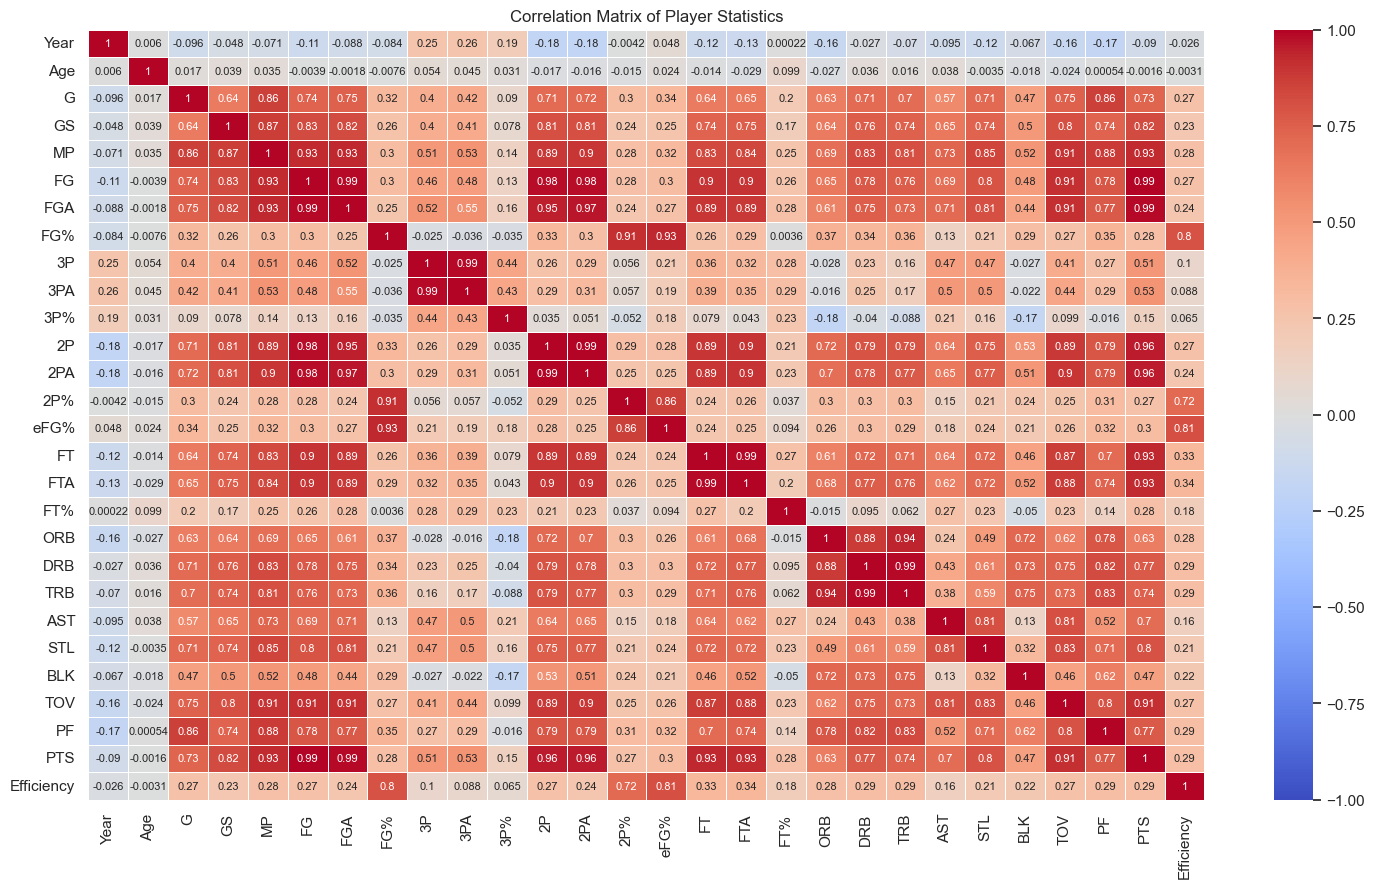

In [13]:
# Calculate the correlation coefficient matrix
filtered_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = filtered_df.corr()

# Print the correlation coefficients
print(correlation_matrix)

# Set the size of the plot
plt.figure(figsize=(18, 10))

# Set the plot style
sns.set(style='white')

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8}, vmin=-1, vmax=1)

# Rotate axis labels for better visibility
plt.xticks(ha='center')
plt.yticks(va='center')

# Add a title
plt.title('Correlation Matrix of Player Statistics')

# Display the heatmap
plt.show()

We can draw the following noteworthy conclusions:
- `PTS` and `Efficiency`: `0.287`: Efficiency has a medium to low correlation with points (PTS). **High points do not mean high efficiency.** Efficiency depends more on the comprehensive performance of shooting percentage, assists, rebounds, steals, etc.

- `TRB` and `MP`: `0.808` / `STL` and `MP`: `0.849` shows that traditional statistics (assists, rebounds, steals) are strongly correlated with playing time. **The more playing time, the more data a player accumulates**, especially core players, who have **higher data performance in multiple dimensions.**

- `3P` and `3PA`: `0.941`, while `3P%` and `Efficiency` are lower, only about `0.13`. This shows that three-point data are strongly correlated with each other, but have **little impact on efficiency**. Players who take more shots usually hit more, but the hit rate has limited effect on improving efficiency.


## 3.4. Final classification of players
Based on the analysis in this section, we now use the K-Means classifier to classify the players into three categories

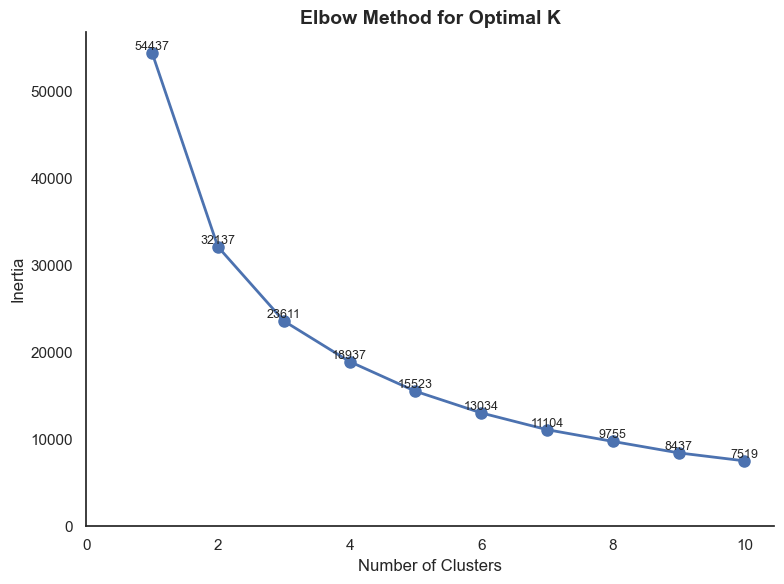

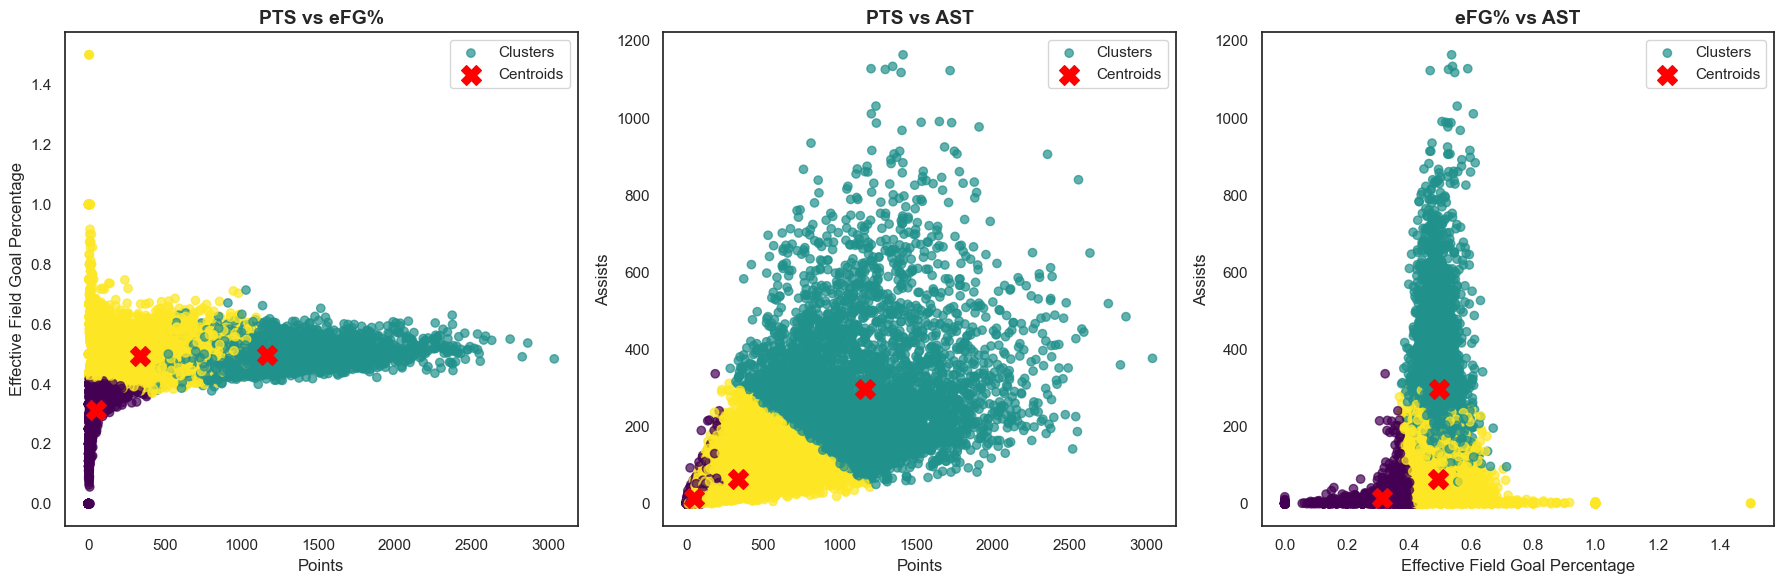

In [14]:


clustering_features = df[['PTS', 'eFG%', 'AST']]
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)


inertia = []
k_range = range(1, 11)
for k in k_range:
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_features_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

for i, val in enumerate(inertia):
    plt.text(k_range[i], val, str(int(val)), fontsize=9, ha='center', va='bottom')

plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.tight_layout()
plt.show()


optimal_k_clusters = 3
kmeans = KMeans(n_clusters=optimal_k_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(clustering_features_scaled)


centroids = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids)


fig, axs = plt.subplots(1, 3, figsize=(18, 6))


axs[0].scatter(df['PTS'], df['eFG%'], c=df['Cluster'], cmap='viridis', label='Clusters', alpha=0.7)
axs[0].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
axs[0].set_xlabel('Points', fontsize=12)
axs[0].set_ylabel('Effective Field Goal Percentage', fontsize=12)
axs[0].set_title('PTS vs eFG%', fontsize=14, fontweight='bold')
axs[0].legend()

axs[1].scatter(df['PTS'], df['AST'], c=df['Cluster'], cmap='viridis', label='Clusters', alpha=0.7)
axs[1].scatter(centroids[:, 0], centroids[:, 2], c='red', marker='X', s=200, label='Centroids')
axs[1].set_xlabel('Points', fontsize=12)
axs[1].set_ylabel('Assists', fontsize=12)
axs[1].set_title('PTS vs AST', fontsize=14, fontweight='bold')
axs[1].legend()


axs[2].scatter(df['eFG%'], df['AST'], c=df['Cluster'], cmap='viridis', label='Clusters', alpha=0.7)
axs[2].scatter(centroids[:, 1], centroids[:, 2], c='red', marker='X', s=200, label='Centroids')
axs[2].set_xlabel('Effective Field Goal Percentage', fontsize=12)
axs[2].set_ylabel('Assists', fontsize=12)
axs[2].set_title('eFG% vs AST', fontsize=14, fontweight='bold')
axs[2].legend()

plt.tight_layout()
plt.show()



The overall purpose of this part is to use **K-Means** clustering analysis to identify different clusters (i.e. similar types of players) based on player scoring, shooting accuracy, and assist data, and to visualize the clustering effect and center position. 

Based on the **elbow diagram** drawn, display the K values that appear in this step. Choose K value of 3 according to the inflection point. Then, since we have selected three variables to classify players，and this will be a three-dimensional space. In order to clearly see the boundary positions of each class, we need to use three flat graphs to display the clustering of players, with the basic information of each cluster labeled. 

In this way, we divide NBA players into **3 categories** *("star players," "average players," and "bench players").*: 
- the first category performs well in scoring, shooting accuracy, and assist data
- The second category performs well in some aspects but not very well in others
- The third category performs poorly in all these aspects 

# 4.Quesion3: Team tactical strategy
All data analysis is for the purpose of improving and upgrading the status quo. We are committed to finding a more efficient and documented way of scoring and its corresponding strategic layout method for the team.

In the NBA, especially in the recent **"Small Ball Era"**, the most common problem encountered by the team is the **2-point vs. 3-point** battle, and many well-known systems such as "Moneyball Tactics" and "Run and Gun Tactics" have emerged.
- **Moneyball**: Identify and recruit underrated players to build an efficient team at minimal cost
- **Run and Gun**: A fast-attack basketball tactic that emphasizes **fast advancement and high-frequency shooting**, with the goal of suppressing opponents through a high-tempo game style and increasing scoring opportunities.

Below we will intuitively show the **top scoring teams' three-point usage and scoring composition**, so as to help the team choose a more appropriate tactical arrangement.

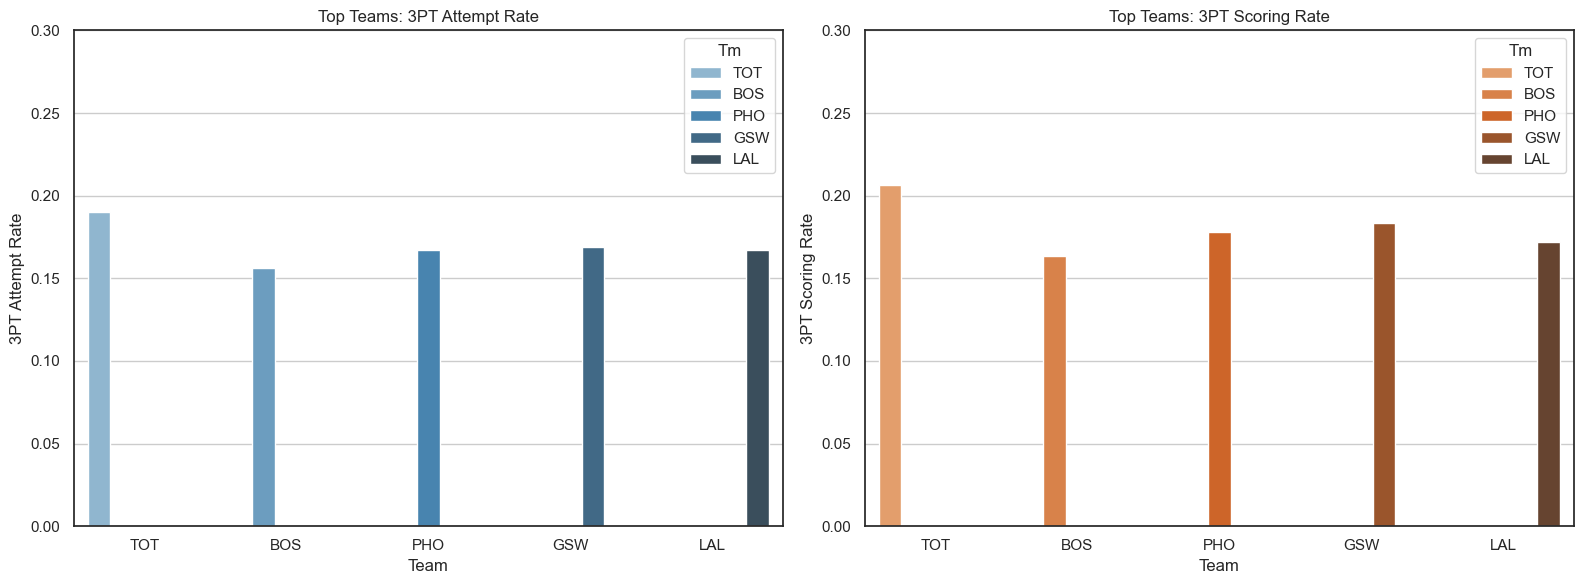

In [15]:
team_stats = df.groupby('Tm').agg({
    'FGA': 'sum',  
    '3PA': 'sum',   
    '3P': 'sum',    
    'FG': 'sum'     
}).reset_index()


team_stats['2PA'] = team_stats['FGA'] - team_stats['3PA']
team_stats['2P'] = team_stats['FG'] - team_stats['3P']


team_stats['3P_PTS'] = team_stats['3P'] * 3
team_stats['2P_PTS'] = team_stats['2P'] * 2
team_stats['PTS'] = team_stats['3P_PTS'] + team_stats['2P_PTS']


team_stats['3PA_rate'] = team_stats['3PA'] / team_stats['FGA']             
team_stats['3P_PTS_rate'] = team_stats['3P_PTS'] / team_stats['PTS']   
top_teams = team_stats.sort_values(by='PTS', ascending=False).head(5)
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 3PT Attempt Rate
sns.barplot(data=top_teams, x='Tm', y='3PA_rate', hue='Tm', palette='Blues_d', ax=axes[0])
axes[0].set_title('Top Teams: 3PT Attempt Rate')
axes[0].set_ylabel('3PT Attempt Rate')
axes[0].set_xlabel('Team')
axes[0].set_ylim(0, 0.3)
axes[0].grid(axis='y')

# Plot 3PT Scoring Rate
sns.barplot(data=top_teams, x='Tm', y='3P_PTS_rate', hue='Tm', palette='Oranges_d', ax=axes[1])
axes[1].set_title('Top Teams: 3PT Scoring Rate')
axes[1].set_ylabel('3PT Scoring Rate')
axes[1].set_xlabel('Team')
axes[1].set_ylim(0, 0.3)
axes[1].grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.show()


To analyze the top scoring teams’ three-point shooting and scoring composition, we did the following:
- Calculate team-level shooting statistics from raw data
- Derive two-point shooting related metrics
- Calculate score and ratio metrics
- Filter out the top five scoring teams
- Use two bar charts to show the top teams’ three-point shooting tendency (3PA_rate) and three-point scoring contribution (`3P_PTS_rate`)

After analysis, we found that:
For these five teams with the strongest scoring ability, the proportion of three-point shots to total shots and the proportion of three-point scores to total scores are very close
- This actually shows that the scoring contribution of a three-point shot and a two-point shot is **almost the same**. Although a three-point shot scores one more point than a two-point shot, the low hit rate caused by uncertainty offsets this.

At the same time, for these five teams with the strongest scoring ability, the proportion of three-pointers in the total score is close to and less than 20%, which shows that **three-pointers cannot be used as a conventional weapon for the team to survive, and two-pointers will always be the most reliable scoring method for top teams**; however, three-pointers close to 20% also show that three-pointers are an indispensable offensive method, **and the team must have stable three-point firepower to open up the situation**. After all, three-pointers are always the best weapon to crack the double-team defense tactics.

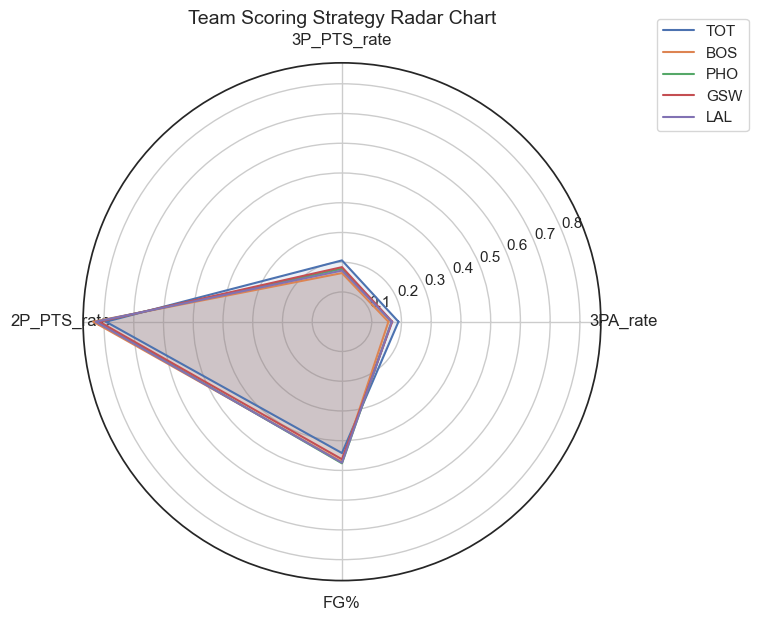

In [16]:
top_teams['2P_PTS_rate'] = top_teams['2P_PTS'] / top_teams['PTS']
top_teams['FG%'] = top_teams['FG'] / top_teams['FGA']

radar_df = top_teams[['Tm', '3PA_rate', '3P_PTS_rate', '2P_PTS_rate', 'FG%']].copy()

labels = ['3PA_rate', '3P_PTS_rate', '2P_PTS_rate', 'FG%']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in radar_df.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row['Tm'])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
plt.title('Team Scoring Strategy Radar Chart', size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()



In [17]:
print(radar_df[['Tm'] + labels])


     Tm  3PA_rate  3P_PTS_rate  2P_PTS_rate       FG%
36  TOT  0.189939     0.206182     0.793818  0.441644
1   BOS  0.156207     0.163616     0.836384  0.471571
29  PHO  0.167229     0.178052     0.821948  0.476184
11  GSW  0.169059     0.183514     0.816486  0.462562
16  LAL  0.167320     0.171980     0.828020  0.474262


Here we can see the specific data:
- `3PA_rate` (three-point shooting rate): the higher the team relies more on three-pointers.
- `3P_PTS_rate` (three-point scoring percentage): the higher the three-pointer contributes more to the total score.
- `2P_PTS_rate` (two-point scoring percentage): the higher the team relies more on two-pointer scoring.
- `FG%` (total hit rate): measures the overall shooting efficiency of the team.

After analysis, it is not difficult to see that:
TOT's three-pointers are significantly higher than the other four teams in terms of both shooting percentage and scoring percentage, which also brings an intuitive impact: TOT's total hit rate is significantly lower than the other four teams. Combined with history, it is not difficult to see that TOT has only one championship, which is far inferior to BOS, PHO, GSW, LAL and other powerful teams. This fully illustrates that the way of **playing that relies too much on three-pointers is unreliable in key games** such as the playoffs, and the uncertainty brought by low hit rates is fatal in key games.

### 4.1. Conclusion
In summary, we can draw the following conclusions:
- A top team needs to shoot about **`15%~20%` of three-pointers** to open up the game
- The most core scoring method must be **two-pointers**
- **"Moneyball tactics" is difficult to win the championship.**

# 5.Question4 Analysis of the gap between teams
In order to explore the differences in player scores between different teams, we selected four well-known teams
- Boston Celtics
- Los Angeles Lakers
- Chicago Cardinals
- Miami Heat

(BOS, LAL, CHI, MIA) 

For each team, we present the player scores in the form of box plots and use **t-test (two-tailed test)** to compare the scores of each pair of players between these four teams, then calculate **P value** and draw **heat map**.

In [18]:


selected_teams = ['LAL', 'BOS', 'CHI', 'MIA']  

t_test_results = {}
for i in range(len(selected_teams)):
    for j in range(i + 1, len(selected_teams)):
        team1 = selected_teams[i]
        team2 = selected_teams[j]
        scores_team1 = df[df['Tm'] == team1]['PTS']
        scores_team2 = df[df['Tm'] == team2]['PTS']
        t_stat, p_value = stats.ttest_ind(scores_team1, scores_team2, equal_var=False)
        t_test_results[(team1, team2)] = {
            't_statistic': t_stat,
            'p_value': p_value
        }


fig_box = px.box(
    df[df['Tm'].isin(selected_teams)],
    x='Tm',
    y='PTS',
    title='Box Plot of Player Scores by Team',
    points="all"  
)
fig_box.update_layout(width=800, height=600)


ttest_df = pd.DataFrame(
    [
         {
             'Comparison': f'{team1} vs {team2}',
             't-statistic': round(res["t_statistic"], 3),
             'p-value': round(res["p_value"], 3)
         } 
         for (team1, team2), res in t_test_results.items()
    ]
)

fig_table = go.Figure(data=[go.Table(
    header=dict(values=list(ttest_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[ttest_df[col] for col in ttest_df.columns],
               fill_color='lavender',
               align='left')
)])
fig_table.update_layout(
    title='T-Test Results Between Selected Teams',
    width=500,
    height=300
)


heatmap_data = pd.DataFrame(index=selected_teams, columns=selected_teams)
for (team1, team2), res in t_test_results.items():
    heatmap_data.loc[team1, team2] = res['p_value']
    heatmap_data.loc[team2, team1] = res['p_value']

heatmap_data = heatmap_data.astype(float).fillna(1)

fig_heatmap = px.imshow(
    heatmap_data,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    title='Heatmap of T-Test P-values Between Selected Teams',
    aspect='auto'
)
fig_heatmap.update_layout(width=500, height=500)

fig_box.show()
fig_table.show()
fig_heatmap.show()



As can be seen from the figure, the P value of Los Angeles Celtics vs. Miami Heat is `0.005`, which can reject the null hypothesis, indicating that there is a significant difference in player scores between Los Angeles Celtics and Miami Heat. The P values ​​of the remaining teams are all greater than `0., indicating that there is no significant difference in player scores between these teams.
## 5.1 Conclusion
We finally found that despite being in different levels of offensive strategies or lineup configurations, the scoring performance of most high-level team players is always **relatively close.** This conclusion is highly consistent with the historical facts of the NBA.

# 6. Question 5: Assign a position to a player
We know that for basketball games, the position of players in the team is very important, which often determines the victory or defeat of the game. This section is to solve a key problem:
> If we have the game data of the players and can analyze their playing strategies, can we use these data to get a machine learning model to provide the players with their best playing positions on the court?

Below we will start with the relevant data of this problem, perform feature engineering, and try to start with the simplest model, build a model, compare the advantages and disadvantages of different models, and finally select the best model to solve this problem.

First, we analyze the target column `Pos`.

In [19]:
df['Pos'].unique()

array(['PG', 'PF', 'SF', 'SG', 'C', 'SG-SF', 'C-PF', 'PF-C', 'SF-SG',
       'SF-PF', 'PG-SG', 'SG-PG', 'PF-SF', 'PG-SF', 'SG-PF', 'C-SF'],
      dtype=object)

In [20]:
df['Pos'].nunique()

16

It is not difficult to find that the current `Pos` column is difficult to meet the training requirements because the "Position" column of some players is a repeated value. We need to remove repeated composite features (like `'SF-PF'`) through feature cleaning and retain single features (like `'PF'`) to make the model more focused on single position classification. We use the following criteria:
- `target.str.contains('-')` → Find labels with - (such as `"SF-PF"`)
- ~ → Negate and retain labels without `-`.

After feature cleaning, we have five types of positions as classification targets. Their codes and names are:
- 0, `PG`
- 1, `PF`
- 2, `SF`
- 3, `SG`
- 4, `C`

At the same time, based on the previous work done in EDA, we selected seven representative features for training, namely points (`PTS`), rebounds (`TRB`), assists (`AST`), steals (`STL`), blocks (`BLK`), field goal percentage (`FG%`), and three-point field goal percentage (`3P%`)

In [21]:
# Use players' statistics as features
features = df[['PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%']]
target = df['Pos']  

# Keep only primary positions, removing categories with hyphens
valid_positions = target[~target.str.contains('-')]

# Get valid indices
valid_indices = valid_positions.index

# Keep only valid samples in features
features = features.loc[valid_indices]

# Ensure the sample sizes of features and target variable match
print("Features shape:", features.shape)
print("Target shape:", valid_positions.shape)
features.head()

Features shape: (17948, 7)
Target shape: (17948,)


,PTS,TRB,AST,STL,BLK,FG%,3P%
0,1131.0,197.0,671.0,106.0,10.0,0.482,0.222
1,1745.0,852.0,370.0,143.0,53.0,0.474,0.406
2,914.0,330.0,156.0,120.0,36.0,0.474,0.293
3,167.0,73.0,38.0,31.0,11.0,0.354,0.167
4,940.0,534.0,206.0,69.0,61.0,0.453,0.083


In [22]:
target.head()

0    PG
1    PF
2    SF
3    SG
4     C
Name: Pos, dtype: object

## 6.1 Preliminary study using a simple model
Considering the complexity of this problem, we first tried to use the following strategy to conduct the first preliminary classification exploration when studying this problem. We do not have too much expectation on the effect of this solution. Accordingly, we will propose an improvement plan based on the results of this solution and apply it in the subsequent process (which will appear in the following content of this report):
1. Use Gaussan Native Bayes classifier
2. Use unprocessed features `'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%'` as input

In [23]:
def gaussian_nb(features, valid_positions):
    X_train, X_test, y_train, y_test = train_test_split(features, valid_positions,
                                                        test_size=0.2, random_state=42)


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    nb_model = GaussianNB()


    skf = StratifiedKFold(n_splits=3)
    cv_scores = cross_val_score(nb_model, X_train_scaled, y_train, cv=skf)
    print("Cross-validated accuracy scores:", cv_scores)
    print("Mean cross-validated accuracy:", cv_scores.mean())


    nb_model.fit(X_train_scaled, y_train)

    y_pred = nb_model.predict(X_test_scaled)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0)) 

    y_score = nb_model.predict_proba(X_test_scaled)

    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

    for i, label in enumerate(nb_model.classes_):
        fpr, tpr, _ = roc_curve(y_test == label, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {label} (AUC = {roc_auc:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Gaussian Naive Bayes')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

Cross-validated accuracy scores: [0.45361471 0.45424154 0.45946511]
Mean cross-validated accuracy: 0.4557737846496727
[[459 117  81  15  44]
 [293 181 104  73  87]
 [ 72   8 582   3  75]
 [ 87  75 159 162 211]
 [ 60   9 282  60 291]]
              precision    recall  f1-score   support

           C       0.47      0.64      0.54       716
          PF       0.46      0.25      0.32       738
          PG       0.48      0.79      0.60       740
          SF       0.52      0.23      0.32       694
          SG       0.41      0.41      0.41       702

    accuracy                           0.47      3590
   macro avg       0.47      0.46      0.44      3590
weighted avg       0.47      0.47      0.44      3590



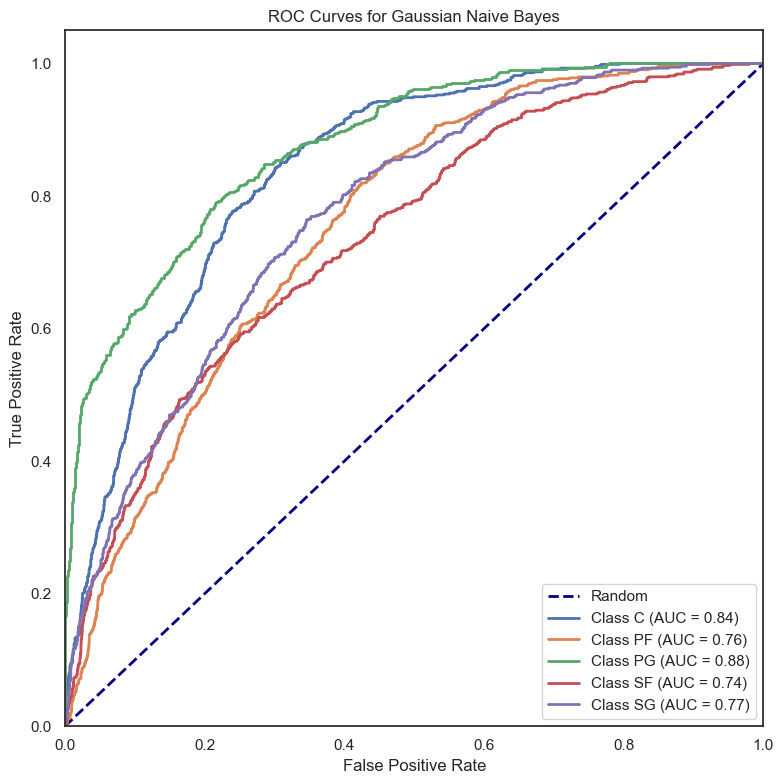

In [24]:
gaussian_nb(features, valid_positions)

## 6.2. Feature Engineering
Basketball positions usually have a strong relative proportional relationship between players' height, weight, athletic ability, assists, defensive ability, etc. K-NN is an algorithm based on distance calculation, which is very sensitive to feature scale and proportional relationship. After combining the data and referring to real cases, we introduce the following new features:

1. Assist-to-turnover ratio (AST/TO) `AST_TO`
$$
\text{AST/TO} = \frac{\text{AST}}{\text{TOV} + 1}
$$

> Measures ball control stability, PG is usually higher

2. Defensive strength index (BLK + STL) `DefenseIndex`
$$
\text{DefenseIndex} = \text{BLK} + \text{STL}
$$

> Inside players have more blocks and outside players have more steals

3. Offensive usage rate index `Usage`
$$
\text{Usage} = \frac{\text{PTS + AST}}{\text{MP} + 1}
$$

> Ball handlers and main scorers will be higher (such as PG and SG)

### 5.2.1 Feature Construction
In this section, we will construct these three new features and update the dataset.

In [25]:
df['AST_TO'] = df['AST'] / (df['TOV'] + 1)  #preventing division by 0
df['DefenseIndex'] = df['BLK'] + df['STL']
df['Usage'] = (df['PTS'] + df['AST']) / (df['MP'] + 1)  

# distribution
df[['AST_TO', 'DefenseIndex', 'Usage']].describe()

,AST_TO,DefenseIndex,Usage
count,18146.000000,18146.000000,18146.000000
mean,1.325335,62.611044,0.453589
std,0.876676,60.117746,0.152231
min,0.000000,0.000000,0.000000
25%,0.693878,15.000000,0.352941
50%,1.153846,47.000000,0.447893
75%,1.807576,94.000000,0.547222
max,12.000000,550.000000,1.666667


In [26]:
# Use players' statistics as features
new_features = df[['PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'AST_TO', 'DefenseIndex', 'Usage']]
target = df['Pos']  

# Keep only primary positions, removing categories with hyphens
valid_positions = target[~target.str.contains('-')]

# Get valid indices
valid_indices = valid_positions.index

# Keep only valid samples in features
new_features = new_features.loc[valid_indices]

# Ensure the sample sizes of features and target variable match
print("Features shape:",new_features.shape)
print("Target shape:", valid_positions.shape)
features.head()

Features shape: (17948, 10)
Target shape: (17948,)


,PTS,TRB,AST,STL,BLK,FG%,3P%
0,1131.0,197.0,671.0,106.0,10.0,0.482,0.222
1,1745.0,852.0,370.0,143.0,53.0,0.474,0.406
2,914.0,330.0,156.0,120.0,36.0,0.474,0.293
3,167.0,73.0,38.0,31.0,11.0,0.354,0.167
4,940.0,534.0,206.0,69.0,61.0,0.453,0.083


### 6.2.2 Test
Use the same model structure and the data with new features added for training and testing.

Cross-validated accuracy scores: [0.49394066 0.49832846 0.51964062]
Mean cross-validated accuracy: 0.5039699122440452
[[461 200   3  19  33]
 [267 266   2  78 125]
 [ 26  27 488   0 199]
 [ 72 109  25 179 309]
 [ 51  30 115  62 444]]
              precision    recall  f1-score   support

           C       0.53      0.64      0.58       716
          PF       0.42      0.36      0.39       738
          PG       0.77      0.66      0.71       740
          SF       0.53      0.26      0.35       694
          SG       0.40      0.63      0.49       702

    accuracy                           0.51      3590
   macro avg       0.53      0.51      0.50      3590
weighted avg       0.53      0.51      0.50      3590



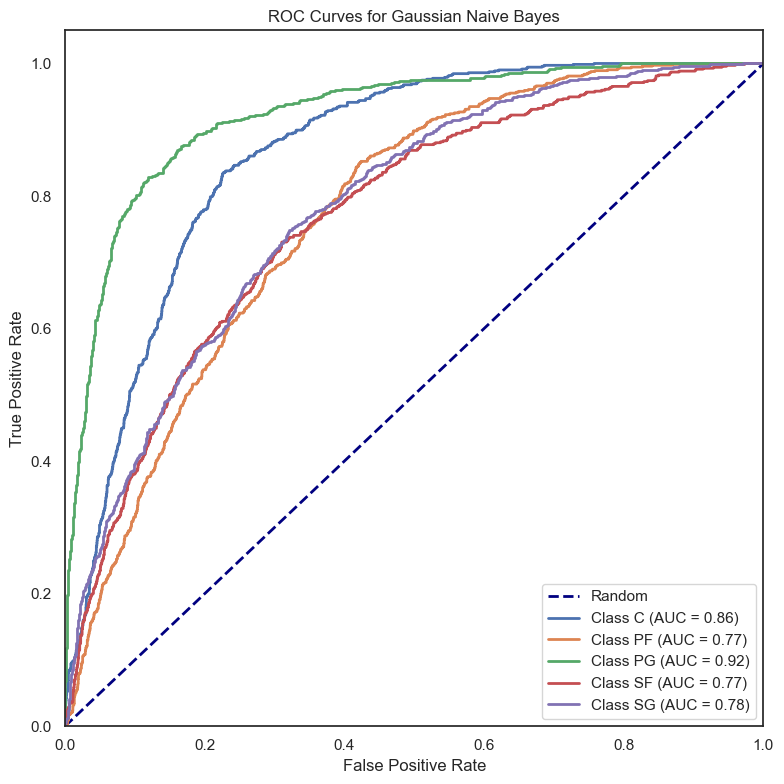

In [27]:
gaussian_nb(new_features, valid_positions)

As we can see, feature engineering is very effective:
- Using the original dataset, the average accuracy is only `0.47`, even lower than the baseline
- The average accuracy of the model trained with the new dataset reaches `0.53`.

Next, we can use the new dataset to try to get a more effective model.

## 6.3. Model Choosing
In this section, we will try several more effective models and finally select the best model through comparison.
### 6.3.1 KNN
First, try the classic KNN model.

In [28]:
def knn(features, valid_positions):
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, valid_positions, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Use StratifiedKFold for cross-validation
    k_values = range(1, 31)
    mean_scores = []
    plt.figure(figsize=(15, 6))
    skf = StratifiedKFold(n_splits=3)  # Use 3-fold cross-validation

    # Store ROC data for the best K values and their surrounding K values
    roc_data = {}

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train_scaled, y_train, cv=skf)
        mean_scores.append(scores.mean())

        # Only plot ROC curves when finding the best K value and its neighboring K values
        if k in [k_values[mean_scores.index(max(mean_scores))], 
                  k_values[mean_scores.index(max(mean_scores))] - 1, 
                  k_values[mean_scores.index(max(mean_scores))] + 1]:
            for train_index, test_index in skf.split(X_train_scaled, y_train):
                X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
                y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

                knn.fit(X_train_fold, y_train_fold)
                y_score = knn.predict_proba(X_test_fold)

                # Calculate ROC curve
                for i, label in enumerate(knn.classes_):
                    fpr, tpr, _ = roc_curve(y_test_fold == label, y_score[:, i])
                    roc_auc = auc(fpr, tpr)

                    if k not in roc_data:
                        roc_data[k] = {}
                    roc_data[k][label] = (fpr, tpr, roc_auc)

    # Plot the relationship between K values and mean scores
    plt.subplot(1, 2, 1)
    plt.plot(k_values, mean_scores)
    plt.xlabel('K Value')
    plt.ylabel('Mean Cross-Validated Accuracy')
    plt.title('Optimal K Value for K-NN')
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlim(left=0)

    # Select the optimal K value
    optimal_k = k_values[mean_scores.index(max(mean_scores))]
    print(f'Optimal K: {optimal_k}')

    # Train the model using the optimal K value
    knn = KNeighborsClassifier(n_neighbors=optimal_k)
    knn.fit(X_train_scaled, y_train)

    # Predict and evaluate
    y_pred = knn.predict(X_test_scaled)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))  # Use zero_division parameter

    # Plot ROC curves
    plt.subplot(1, 2, 2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for K-NN')

    # Plot ROC curves for the optimal K value and its neighboring K values
    for k in [optimal_k - 1, optimal_k, optimal_k + 1]:
        if k in roc_data:
            for label in roc_data[k]:
                fpr, tpr, roc_auc = roc_data[k][label]
                plt.plot(fpr, tpr, label=f'K = {k}, Class = {label} (AUC = {roc_auc:.2f})')

    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

Optimal K: 22
[[455 194  12  36  19]
 [224 338   8 132  36]
 [ 18  13 579  18 112]
 [ 49 141  33 287 184]
 [ 24  36 156 149 337]]
              precision    recall  f1-score   support

           C       0.59      0.64      0.61       716
          PF       0.47      0.46      0.46       738
          PG       0.73      0.78      0.76       740
          SF       0.46      0.41      0.44       694
          SG       0.49      0.48      0.48       702

    accuracy                           0.56      3590
   macro avg       0.55      0.55      0.55      3590
weighted avg       0.55      0.56      0.55      3590



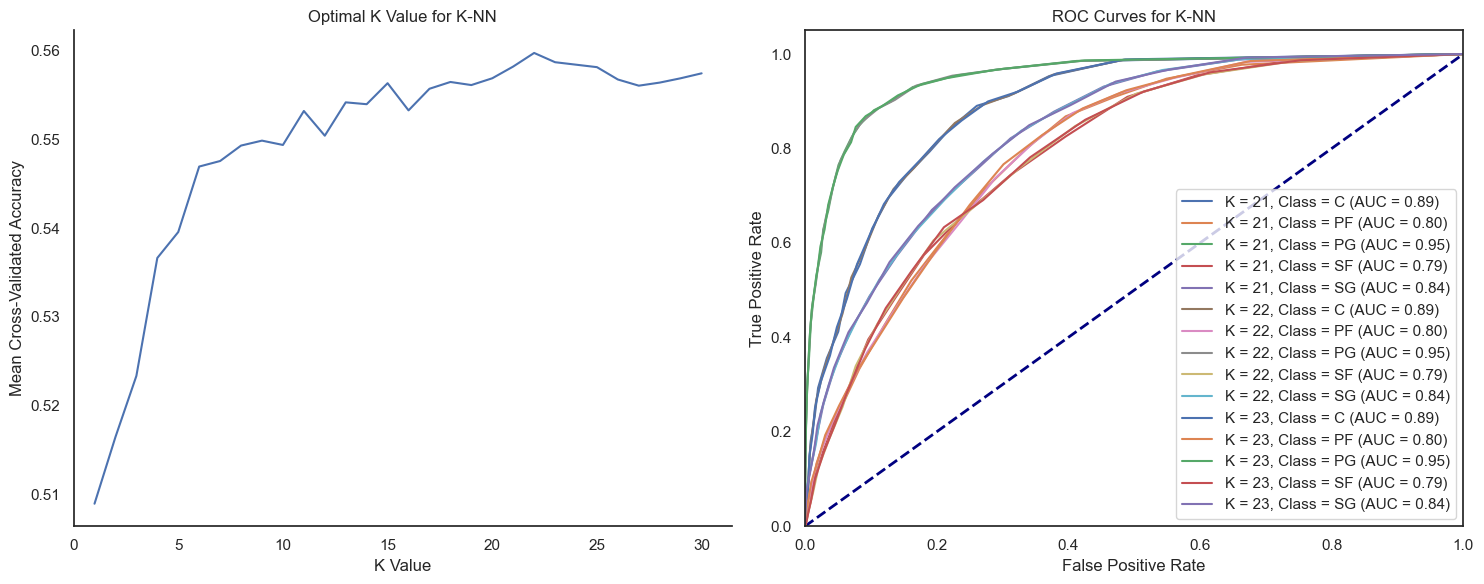

In [29]:
knn(new_features, valid_positions)

We found that under the optimal hyperparameter (`k=22`), the average accuracy of KNN has exceeded Gaussan Native Bayes and reached `0.56`, but this still cannot meet our requirements. Next, we will analyze the improvement direction and study new model selection:

- **Random Forest** can automatically handle the importance of features and is more robust to the problem of class imbalance.

### 6.3.2 Random Forest

In [30]:
def random_forest(features, valid_positions):
    X_train, X_test, y_train, y_test = train_test_split(features, valid_positions, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    estimators_range = range(10, 101, 10)
    mean_scores = []
    plt.figure(figsize=(15, 6))
    skf = StratifiedKFold(n_splits=3)  


    roc_data = {}

    for n in estimators_range:
        rf = RandomForestClassifier(n_estimators=n, random_state=42)

        scores = cross_val_score(rf, X_train_scaled, y_train, cv=skf)
        mean_scores.append(scores.mean())

    
        best_n = list(estimators_range)[mean_scores.index(max(mean_scores))]
        if n in [best_n - 10, best_n, best_n + 10]:
            for train_index, test_index in skf.split(X_train_scaled, y_train):
                X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
                y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

                rf.fit(X_train_fold, y_train_fold)

                y_score = rf.predict_proba(X_test_fold)


                for i, label in enumerate(rf.classes_):
                    fpr, tpr, _ = roc_curve(y_test_fold == label, y_score[:, i])
                    roc_auc = auc(fpr, tpr)

                    if n not in roc_data:
                        roc_data[n] = {}
                    roc_data[n][label] = (fpr, tpr, roc_auc)


    plt.subplot(1, 2, 1)
    plt.plot(list(estimators_range), mean_scores, marker='o')
    plt.xlabel('n_estimators')
    plt.ylabel('Mean Cross-Validated Accuracy')
    plt.title('Optimal n_estimators for Random Forest')
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlim(min(estimators_range)-5, max(estimators_range)+5)

    optimal_n = list(estimators_range)[mean_scores.index(max(mean_scores))]
    print(f'Optimal n_estimators: {optimal_n}')

    rf = RandomForestClassifier(n_estimators=optimal_n, random_state=42)
    rf.fit(X_train_scaled, y_train)


    y_pred = rf.predict(X_test_scaled)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))


    plt.subplot(1, 2, 2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Random Forest')

    for n in [optimal_n - 10, optimal_n, optimal_n + 10]:
        if n in roc_data:
            for label in roc_data[n]:
                fpr, tpr, roc_auc = roc_data[n][label]
                plt.plot(fpr, tpr, label=f'n_estimators = {n}, Class = {label} (AUC = {roc_auc:.2f})')

    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


Optimal n_estimators: 100
[[472 194   1  36  13]
 [222 360   3 129  24]
 [  2   1 614  20 103]
 [ 42 129  23 338 162]
 [  3  26 133 159 381]]
              precision    recall  f1-score   support

           C       0.64      0.66      0.65       716
          PF       0.51      0.49      0.50       738
          PG       0.79      0.83      0.81       740
          SF       0.50      0.49      0.49       694
          SG       0.56      0.54      0.55       702

    accuracy                           0.60      3590
   macro avg       0.60      0.60      0.60      3590
weighted avg       0.60      0.60      0.60      3590



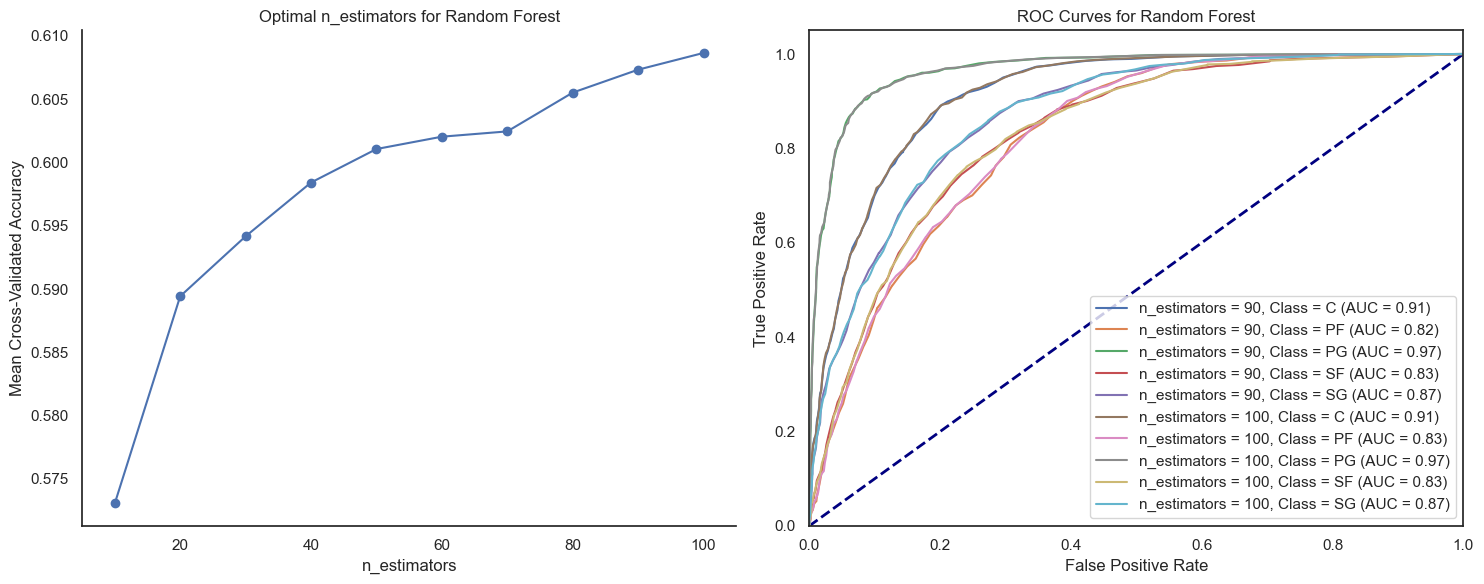

In [31]:
random_forest(new_features, valid_positions)


**Random Forest performs the best**, has the highest overall accuracy, and is more accurate in predicting multiple categories (especially PG).

The sub-optimal results for KNN may be due to the large size of the data, resulting in KNN not performing as well as Random Forest on high-dimensional data.

Of all the models:
-  the `PG` (point guard) position was the most consistently predicted, while the `SF` (small forward) position was more difficult to predict.
-  Because the `SF` role has greater diversity in the actual game, leading to increased classification difficulty.


## 6.4. Player Position Prediction Program
Our goal is to provide suggestions for player position strategies. Now we try to use the trained random forest model to predict the best position of the input player.

We have obtained the **best hyperparameters** of the **random forest model** in previous work, which is `n_estimators=80`. Now we use this parameter to train and save a model in the current directory, and then run a script that will:
- Receive the input player ID
- Output the best position of the player predicted by the model

In [32]:
import joblib


def train_and_save_simple_rf(features, valid_positions):
    # divide train set & test set
    X_train, X_test, y_train, y_test = train_test_split(features, valid_positions, test_size=0.2, random_state=42)

    # normalize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # train（n_estimators = 80）
    rf = RandomForestClassifier(n_estimators=80, random_state=42)
    rf.fit(X_train_scaled, y_train)

    # save
    joblib.dump(rf, 'rf_model.joblib')
    joblib.dump(scaler, 'scaler.joblib')
    print("\n model saved as  rf_model.joblib")
    print(" Scaler saved as scaler.joblib")

    return rf, scaler


In [33]:
rf_model, scaler = train_and_save_simple_rf(new_features, valid_positions)



 model saved as  rf_model.joblib
 Scaler saved as scaler.joblib


In [34]:
import joblib

# Load the model and scaler
rf = joblib.load("rf_model.joblib")
scaler = joblib.load("scaler.joblib")

def predict_position_by_index(index, features):
    """
    Predict the position of a player by index from the feature DataFrame.

    Parameters:
    - index: int, the index of the player in the features DataFrame
    - features: pd.DataFrame, the input features used for prediction
    """
    if index not in features.index:
        print(f"Index {index} not found in the dataset.")
        return

    # Extract and scale the player's feature vector
    player_features = features.loc[index].values.reshape(1, -1)
    player_features_scaled = scaler.transform(player_features)

    # Predict position and get probabilities
    pred = rf.predict(player_features_scaled)[0]
    probs = rf.predict_proba(player_features_scaled)[0]

    print(f"\n Predicted position for player at index {index}: {pred}")
    print("Class probabilities:")
    for pos, prob in zip(rf.classes_, probs):
        print(f"  {pos}: {prob:.2%}")



Now let's try to predict the best positioning for the No.4 player.

In [35]:
# Example: Predict the position for player at index 4
predict_position_by_index(4, new_features)



 Predicted position for player at index 4: C
Class probabilities:
  C: 68.75%
  PF: 17.50%
  PG: 0.00%
  SF: 13.75%
  SG: 0.00%


d:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



The results show that the No. 4 player is best suited to play as a **center (`C`)**.

# 7. Conclusion


After the above analysis and discussion, I have successfully completed the exploration.

## To filling the Missing Values
I use the following strategy:
1. Convert Numeric Columns to Numeric Types
2. Replace Empty Strings with `NaN`
3. Fill Each Numeric Column with the **Average Value** for NaN Values
4. Remove Leading and Trailing Spaces
6. Remove Corrupted Data
7. Delete All Columns with "Unnamed"

## To classify players into different type
I use the following strategy:
1. Calculate the median and mean of the players' performance.
2. Analyze **Total Points**, **Total Assists**, **Scoring Efficiency**.
3. Analyze the correlation between different numerical statistical indicators in basketball player data and visualize these relationships.
4. Use the K-Means classifier to classify the players into three categories.
### I get the following inference:
• In basketball, a few players contribute significantly to the game, while most 
players perform relatively average.
• Total points and total assists are greatly affected by the extremely high 
performance of a few top players, while scoring efficiency is relatively stable.
• It is feasible to divide players into three categories ("star players", "simple 
players" and "bench players"), and most players are simple players.

## To research team tactical strategy
I use the following strategy:
1. Show the **top scoring teams' three-point usage and scoring composition**
2. Analyze the weight ratio of two pointers and three pointers
3. Draw conclusions on how to optimize players' shooting choices
### II get the following inference:
• Three-pointers cannot be used as a conventional weapon for the 
team to survive
• Two-pointers will always be the most reliable scoring method for 
top teams
• But a top team needs to shoot about 15%~20% of three-pointers 
to open up the game
• "Moneyball tactics" is difficult to win the championship

## To analysis the gap between teams
I use the following strategy:
1. Select four well-known teams (BOS, LAL, CHI, MIA) 
2. Present the player scores in the form of box plots
3. Use **t-test (two-tailed test)** to compare the scores of each pair of players between these four teams
4. Calculate **P value** and draw **heat map**
### I get the following inference:
• Not all teams have significant differences, only top tier teams and
relatively weaker teams have differences. 
• Varying levels of development in the cities and regions where they 
are located, resulting in significant differences in consumption levels 
and team assets. 
• Big cities like Boston and Los Angeles clearly have more funds to 
recruit better players.

## To assign a position to a player
I use the following strategy:
1. Preliminary study using a simple model
2. Select relevant data of this problem and perform feature engineering
3. Try several more effective models and finally select the best model through comparison (random forest model)
4. Use the selected parameter to train and save the model in the current directory, and then run a script that will:
- Receive the input player ID
- Output the best position of the player predicted by the model
#### In the end, I found the most suitable model (random forest model)